In [1]:
from linearmodels.panel import PooledOLS, PanelOLS

import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from statsmodels.iolib.summary2 import summary_col

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from urllib.request import urlopen
import json
import plotly
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [2]:
def plotByState(dataset, valueColName, colorbarLabel, saveFilePath, stateColName = 'state_code'):
    #Extract only state data

    valueRange = (min(dataset[valueColName]), max(dataset[valueColName]))

    fig = px.choropleth(dataset, locations=dataset[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:colorbarLabel},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(saveFilePath, auto_open=True)

## Read in data

In [3]:
us_daily = pd.read_csv("data/cleaned/daily_df.csv", index_col=0)
us_daily["date"] = pd.to_datetime(us_daily["date"])
us_daily = us_daily.set_index("date")

In [4]:
us_monthly = us_daily.groupby([pd.Grouper(freq='M'), 'state']).mean()
us_monthly
us_monthly = pd.DataFrame(us_monthly.to_records())

In [5]:
micperceptions = pd.read_csv("data/cleaned/misperception_state_inferred.csv", index_col=0)
micperceptions = pd.DataFrame(micperceptions.to_records())
micperceptions.columns = ["state", "pc_misconception"]
micperceptions.pc_misconception = micperceptions.pc_misconception.str.rstrip('%').astype('float') / 100.0

In [6]:
us_cross_sectional = us_daily.loc[(us_daily.index >= "2020-03-01") & (us_daily.index <= "2021-01-31")].groupby(["state"]).mean()
us_Aug = us_daily.loc[(us_daily.index >= "2020-08-01") & (us_daily.index <= "2021-08-31")].groupby(["state"]).mean()

In [7]:
us_cross_sectional = pd.merge(us_cross_sectional, micperceptions, on="state")
us_Aug = pd.merge(us_Aug, micperceptions, on="state")

In [8]:
reported_compliance = pd.read_csv("data/covidstates/beh_2.csv", index_col=0)

US_state_abb = pd.read_csv("data/US_state_abb.csv")
US_state_abb.columns = ["state", "state_abb"]
reported_compliance = pd.merge(reported_compliance, US_state_abb, on="state_abb", how="left")

In [9]:
reported_compliance.columns = ["state_abb", "not_at_all", "not_very", "somewhat", "very", "error_margin", "N", "wave", "state"]

In [10]:
news_source = pd.read_csv("data/news_source.csv", index_col=0)
news_source = news_source.rename({'state': 'state_abb'}, axis=1)

source_false_prop = pd.read_csv("data/Source_false_prop.csv", index_col=0)

news_source = pd.merge(news_source, US_state_abb, on="state_abb", how="left")

In [11]:
news_source["misinformation_index"] = 0

In [12]:
source_false_prop

,Friends and family,Radio news,Podcasts,Local television,"Network television (e.g. ABC, CBS, or NBC)","Cable television (e.g. CNN, Fox News, or MSNBC)",Late-night comedy shows (e.g. The Late Show with Stephen Colbert or The Daily Show),Print newspapers (e.g. the New York Times or the Wall Street Journal print edition),A news website or app (e.g. the New York Times or Fox News websites or apps),A health website or app (e.g. WebMD),...,Snapchat (website or app),Wikipedia (website or app),Error Margin.1,N.1,CNN,Fox News,MSNBC,President Trump’s press briefings,Error Margin.2,N.2
source,,,,,,,,,,,,,,,,,,,,,
false_percentage,0.13,0.14,0.18,0.11,0.12,0.12,0.16,0.12,0.11,0.17,...,0.26,0.25,NaN,NaN,0.16,0.18,0.15,0.18,NaN,NaN


In [13]:
sources = [
    "Friends and family",
    "Radio news",
    "Podcasts",
    "Local television",
    "Network television (e.g.  ABC, CBS, or NBC)",
    "Late-night comedy shows (e.g. The Late Show with Stephen Colbert or The Daily Show)",
    "Print newspapers (e.g. the New York Times or the Wall Street Journal print edition)",
    "A news website or app (e.g. the New York Times or Fox News websites or apps)",
    "A health website or app (e.g. WebMD)",
    "A government website or app (e.g. CDC.gov)",
    "An organization website or app (e.g. WHO.int)",
    "A search engine website or app (e.g. Google, Bing)",
    "Facebook (website or app)",
    "Twitter (website or app)",
    "Youtube(website or app)",
    "Reddit (website or app)",
    "Instagram (website or app)",
    "Snapchat  (website or app)",
    "Wikipedia (website or app)",
    "CNN",
    "Fox News",
    "MSNBC",
    "President Trump’s press briefings",
]

In [14]:
source = "Friends and family"

In [15]:
index = news_source["misinformation_index"]
for source in sources:
    index = index + news_source[source] * float(source_false_prop[source])
news_source["misinformation_index"] = index
news_misconception = news_source[["state", "wave", "misinformation_index"]]


In [16]:
reported_compliance_cross_sectional = reported_compliance.groupby(["state"]).mean().drop("wave", axis = 1)
news_misconception_cross_sectional = news_misconception.groupby(["state"]).mean().drop("wave", axis = 1)

us_cross_sectional = pd.merge(us_cross_sectional, reported_compliance_cross_sectional, on="state", how="left")
us_cross_sectional = pd.merge(us_cross_sectional, news_misconception_cross_sectional, on="state", how="left")

reported_compliance_Aug = reported_compliance.loc[reported_compliance["wave"] == 9].groupby(["state"]).mean()
news_misconception_Aug = news_misconception.loc[news_misconception["wave"] == 9].groupby(["state"]).mean().drop("wave", axis = 1)

In [17]:
us_Aug = pd.merge(us_Aug, reported_compliance_Aug, on="state", how="left")
us_Aug = pd.merge(us_Aug, news_misconception_Aug, on="state", how="left")

In [18]:
reported_compliance_Aug.columns

Index(['not_at_all', 'not_very', 'somewhat', 'very', 'error_margin', 'N',
       'wave'],
      dtype='object')

## Disease outcomes

In [19]:
us_cross_sectional["deaths_pth"] = 1000 * us_cross_sectional["deathIncrease"] / us_cross_sectional["pop_2019"]
us_Aug["deaths_pth"] = 1000 * us_Aug["deathIncrease"] / us_Aug["pop_2019"]

In [20]:
us_cross_sectional["hospitalized_pth"] = 1000 * us_cross_sectional["hospitalizedIncrease"] / us_cross_sectional["pop_2019"]
us_Aug["hospitalized_pth"] = 1000 * us_Aug["hospitalizedIncrease"] / us_Aug["pop_2019"]

In [21]:
us_cross_sectional["positivity_rate"] = us_cross_sectional["positiveIncrease"] / us_cross_sectional["totalTestResultsIncrease"]
us_Aug["positivity_rate"] = us_Aug["positiveIncrease"] / us_Aug["totalTestResultsIncrease"]

In [22]:
#US State map of misconception and misinformation cross sectional data
with open('data/google_mobility/EDA_and_Viz/states_hash.json', 'r+') as file:
    states_hash = json.load(file)
states_hash = { v:k for (k,v) in states_hash.items()}
us_cross_sectional['state_code'] = us_cross_sectional['state'].map(states_hash)

plotByState(us_cross_sectional, 'pc_misconception', colorbarLabel = 'Misconception %', saveFilePath = 'data/models/state_xsectional_misconception.html')
plotByState(us_cross_sectional, 'misinformation_index', colorbarLabel = 'Misinformation Index', saveFilePath = 'data/models/state_xsectional_misinformation.html')

There is a generally positive relationship between the level of misconceptions and severity of disease outcomes. 

In [23]:
cross_sectional_reg_1_posrate = smf.ols('positivity_rate ~ pc_misconception', data=us_cross_sectional).fit()
cross_sectional_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.447
Date:                Sun, 21 Feb 2021   Prob (F-statistic):              0.235
Time:                        12:51:32   Log-Likelihood:                 73.687
No. Observations:                  51   AIC:                            -143.4
Df Residuals:                      49   BIC:                            -139.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0341      0.052      0.653      0.517      -0.071       0.139
pc_misconception     0.4433      0.369      1.203      0.235      -0.297       1.184
==============================================================================
Omnibus:                       21.919   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.231
Skew:                           1.501   Prob(JB):                     1.65e-07
Kurtosis:                       5.385   Cond. No.                         46.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
cross_sectional_reg_1_dea = smf.ols('deaths_pth ~ pc_misconception', data=us_cross_sectional).fit()
cross_sectional_reg_1_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.436
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0698
Time:                        12:51:32   Log-Likelihood:                 260.03
No. Observations:                  51   AIC:                            -516.1
Df Residuals:                      49   BIC:                            -512.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0013      0.001      0.957      0.343      -0.001       0.004
pc_misconception     0.0177      0.010      1.854      0.070      -0.001       0.037
==============================================================================
Omnibus:                        0.921   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.985
Skew:                           0.231   Prob(JB):                        0.611
Kurtosis:                       2.500   Cond. No.                         46.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
cross_sectional_reg_2_posrate = smf.ols('positivity_rate ~ misinformation_index', data=us_cross_sectional).fit()
cross_sectional_reg_2_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.399
Date:                Sun, 21 Feb 2021   Prob (F-statistic):              0.128
Time:                        12:51:32   Log-Likelihood:                 74.163
No. Observations:                  51   AIC:                            -144.3
Df Residuals:                      49   BIC:                            -140.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2633      0.108      2.435      0.019       0.046       0.481
misinformation_index    -0.0030      0.002     -1.549      0.128      -0.007       0.001
==============================================================================
Omnibus:                       16.987   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.014
Skew:                           1.328   Prob(JB):                     4.51e-05
Kurtosis:                       4.538   Cond. No.                         761.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
cross_sectional_reg_2_dea = smf.ols('deaths_pth ~ misinformation_index', data=us_cross_sectional).fit()
cross_sectional_reg_2_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.238
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0781
Time:                        12:51:32   Log-Likelihood:                 259.94
No. Observations:                  51   AIC:                            -515.9
Df Residuals:                      49   BIC:                            -512.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0013      0.003     -0.461      0.647      -0.007       0.004
misinformation_index  8.974e-05   4.99e-05      1.799      0.078   -1.05e-05       0.000
==============================================================================
Omnibus:                        1.569   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.116
Skew:                           0.010   Prob(JB):                        0.572
Kurtosis:                       2.276   Cond. No.                         761.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
Aug_reg_1_posrate = smf.ols('positivity_rate ~ pc_misconception', data=us_Aug).fit()
Aug_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8389
Date:                Sun, 21 Feb 2021   Prob (F-statistic):              0.364
Time:                        12:51:32   Log-Likelihood:                 61.165
No. Observations:                  51   AIC:                            -118.3
Df Residuals:                      49   BIC:                            -114.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0442      0.067      0.661      0.512      -0.090       0.179
pc_misconception     0.4314      0.471      0.916      0.364      -0.515       1.378
==============================================================================
Omnibus:                       27.005   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.616
Skew:                           1.756   Prob(JB):                     2.05e-10
Kurtosis:                       5.942   Cond. No.                         46.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
print(summary_col([cross_sectional_reg_1_posrate, cross_sectional_reg_1_dea, cross_sectional_reg_2_posrate, cross_sectional_reg_2_dea],stars=True, float_format="%0.4f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                      & positivity\_rate I & deaths\_pth I & positivity\_rate II & deaths\_pth II  \\
\hline
Intercept             & 0.0341             & 0.0013        & 0.2633**            & -0.0013         \\
                      & (0.0523)           & (0.0014)      & (0.1081)            & (0.0028)        \\
R-squared             & 0.0287             & 0.0655        & 0.0467              & 0.0620          \\
R-squared Adj.        & 0.0089             & 0.0465        & 0.0272              & 0.0428          \\
misinformation\_index &                    &               & -0.0030             & 0.0001*         \\
                      &                    &               & (0.0019)            & (0.0000)        \\
pc\_misconception     & 0.4433             & 0.0177*       &                     &                 \\
                      & (0.3685)           & (0.0095)      &                     &                

In [29]:
cross_sectional_reg_3_posrate = smf.ols('positivity_rate ~ pc_misconception + misinformation_index + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.118
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0942
Time:                        12:51:32   Log-Likelihood:                 75.926
No. Observations:                  50   AIC:                            -141.9
Df Residuals:                      45   BIC:                            -132.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1768      0.196      0.900      0.373      -0.219       0.572
pc_misconception         1.1730      0.468      2.508      0.016       0.231       2.115
misinformation_index    -0.0046      0.003     -1.383      0.173      -0.011       0.002
White                    0.0165      0.082      0.201      0.842      -0.149       0.182
Urbanization_rate     6.173e-05      0.001      0.089      0.930      -0.001       0.001
==============================================================================
Omnibus:                       21.595   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.075
Skew:                           1.474   Prob(JB):                     1.79e-07
Kurtosis:                       5.496   Cond. No.                     5.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
cross_sectional_reg_3_dea = smf.ols('deaths_pth ~ pc_misconception + misinformation_index + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2.138
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0916
Time:                        12:51:32   Log-Likelihood:                 257.10
No. Observations:                  50   AIC:                            -504.2
Df Residuals:                      45   BIC:                            -494.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0066      0.005     -1.256      0.215      -0.017       0.004
pc_misconception         0.0216      0.012      1.730      0.090      -0.004       0.047
misinformation_index  8.239e-05    8.9e-05      0.926      0.359   -9.68e-05       0.000
White                    0.0017      0.002      0.779      0.440      -0.003       0.006
Urbanization_rate     1.878e-05   1.86e-05      1.010      0.318   -1.87e-05    5.62e-05
==============================================================================
Omnibus:                        2.294   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                1.439
Skew:                           0.127   Prob(JB):                        0.487
Kurtosis:                       2.208   Cond. No.                     5.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
print(summary_col([cross_sectional_reg_3_posrate, cross_sectional_reg_3_dea],stars=True, float_format="%0.4f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                      & positivity\_rate & deaths\_pth  \\
\hline
Intercept             & 0.1768           & -0.0066      \\
                      & (0.1965)         & (0.0052)     \\
pc\_misconception     & 1.1730**         & 0.0216*      \\
                      & (0.4678)         & (0.0125)     \\
misinformation\_index & -0.0046          & 0.0001       \\
                      & (0.0033)         & (0.0001)     \\
White                 & 0.0165           & 0.0017       \\
                      & (0.0822)         & (0.0022)     \\
Urbanization\_rate    & 0.0001           & 0.0000       \\
                      & (0.0007)         & (0.0000)     \\
R-squared             & 0.1584           & 0.1597       \\
R-squared Adj.        & 0.0836           & 0.0850       \\
\hline
\end{tabular}
\end{center}
\end{table}


In [41]:
us_cross_sectional["pc_misconception"].std()

0.0223374301188325

## Relationship between misconception and mobility

In [32]:
cross_sectional_reg_6_mobility = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misconception + misinformation_index + Urbanization_rate + AverageTemperature",
    data=us_cross_sectional,
).fit()
cross_sectional_reg_6_mobility.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.676
Model:                                                      OLS   Adj. R-squared:                  0.648
Method:                                           Least Squares   F-statistic:                     23.52
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           1.53e-10
Time:                                                  12:51:32   Log-Likelihood:                -168.24
No. Observations:                                            50   AIC:                             346.5
Df Residuals:                                                45   BIC:                             356.0
Df Model:                                                     4                                         
Covariance Type:                                      nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               93.9524     18.023      5.213      0.000      57.653     130.252
pc_misconception       134.9034     62.803      2.148      0.037       8.411     261.396
misinformation_index    -1.5900      0.410     -3.879      0.000      -2.416      -0.764
Urbanization_rate       -0.2340      0.092     -2.538      0.015      -0.420      -0.048
AverageTemperature      -0.9598      0.240     -3.999      0.000      -1.443      -0.476
==============================================================================
Omnibus:                        0.311   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.856   Jarque-Bera (JB):                0.492
Skew:                          -0.040   Prob(JB):                        0.782
Kurtosis:                       2.521   Cond. No.                     5.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
cross_sectional_reg_7_mobility = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misconception +  misinformation_index + Urbanization_rate + AverageTemperature + StringencyIndex",
    data=us_cross_sectional,
).fit()
cross_sectional_reg_7_mobility.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.745
Model:                                                      OLS   Adj. R-squared:                  0.716
Method:                                           Least Squares   F-statistic:                     25.76
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           4.72e-12
Time:                                                  12:51:32   Log-Likelihood:                -162.25
No. Observations:                                            50   AIC:                             336.5
Df Residuals:                                                44   BIC:                             348.0
Df Model:                                                     5                                         
Covariance Type:                                      nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               98.0808     16.213      6.049      0.000      65.405     130.757
pc_misconception        64.3559     59.939      1.074      0.289     -56.444     185.156
misinformation_index    -1.1722      0.387     -3.028      0.004      -1.953      -0.392
Urbanization_rate       -0.2264      0.083     -2.736      0.009      -0.393      -0.060
AverageTemperature      -0.9965      0.216     -4.622      0.000      -1.431      -0.562
StringencyIndex         -0.3581      0.104     -3.451      0.001      -0.567      -0.149
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.004
Skew:                           0.005   Prob(JB):                        0.998
Kurtosis:                       3.043   Cond. No.                     6.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
print(summary_col([cross_sectional_reg_6_mobility, cross_sectional_reg_7_mobility],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                      & non\_residential\_percent\_change\_from\_baseline I & non\_residential\_percent\_change\_from\_baseline II  \\
\hline
AverageTemperature    & -0.960***                                           & -0.997***                                             \\
                      & (0.240)                                             & (0.216)                                               \\
Intercept             & 93.952***                                           & 98.081***                                             \\
                      & (18.023)                                            & (16.213)                                              \\
R-squared             & 0.676                                               & 0.745                                                 \\
R-squared Adj.        & 0.648                                               & 0.716                       

In [35]:
us_daily.loc[us_daily["state"]=="Alaska", "non_residential_percent_change_from_baseline"]

date
2021-02-17     NaN
2021-02-16     NaN
2021-02-15     NaN
2021-02-14     NaN
2021-02-13     NaN
              ... 
2020-03-10     5.0
2020-03-09     3.6
2020-03-08    13.2
2020-03-07    10.2
2020-03-06     6.4
Name: non_residential_percent_change_from_baseline, Length: 349, dtype: float64

### Correlation map

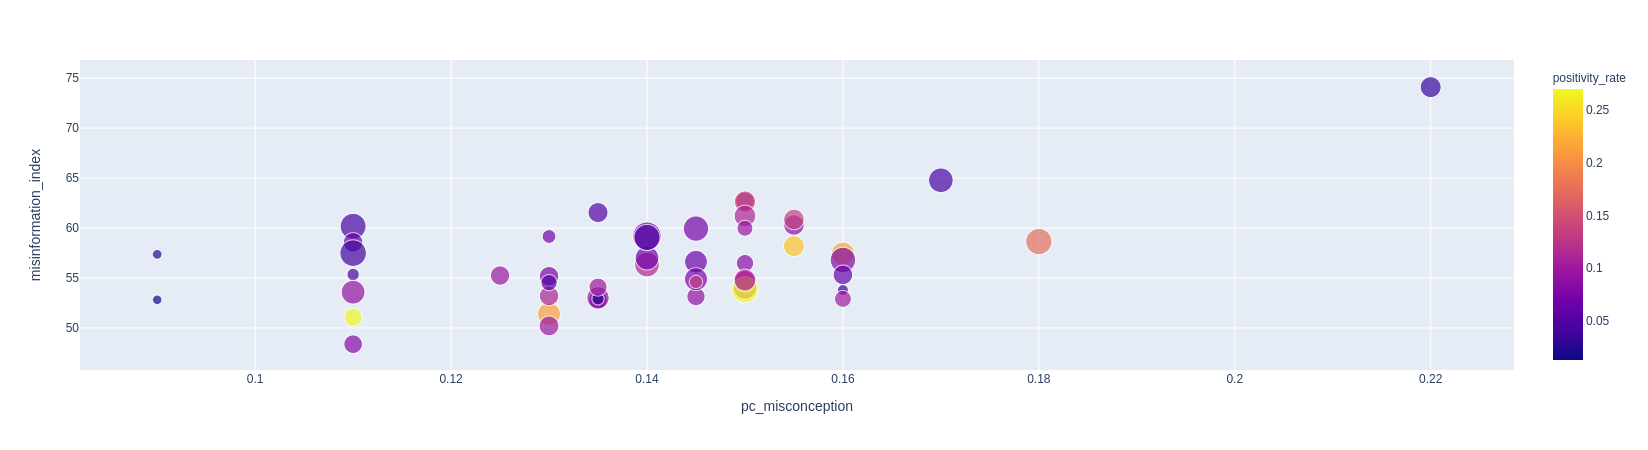

In [49]:
fig = px.scatter(
    us_cross_sectional,
    x="pc_misconception",
    y="misinformation_index",
    color="positivity_rate",
    size="deaths_pth",
    hover_data={"pc_misconception": False, "misinformation_index": False, 'state':True, "deaths_pth": ":.4f", "positivity_rate": ":.1%"},
)
fig.show()

### Save data

In [36]:
us_cross_sectional.to_csv("data/cleaned/us_cross_sectional.csv")

In [44]:
us_cross_sectional["misinformation_index"].std()

4.281135674819144

In [45]:
us_cross_sectional.columns

Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative',
       'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently',
       'onVentilatorCumulative', 'recovered', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg',
       'dataQualityGrade', 'deathIncrease', 'hospitalizedIncrease',
       'commercialScore', 'negativeRegularScore', 'negativeScore',
       'positive